In [1]:
import numpy as np
import pandas as pd
from lathes_model import LathesModel, Lathes_train_test_split

# Carregar base de dados

In [2]:
input_id = 1
INPUT_PATH = 'Input/Input_%i.csv' %input_id

data = np.genfromtxt(INPUT_PATH, delimiter=',')

data.shape

(444000, 9)

Dividir base em treino e teste

In [3]:
X = data[:,:-1]
y = data[:,-1]

X_train, X_test, yy_train, yy_test = Lathes_train_test_split(X, y, test_size=0.3, random_state=12)

print('X_train shape:', X_train.shape)
print('y_train shape:', yy_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', yy_test.shape)

X_train shape: (310500, 8)
y_train shape: (310500,)
X_test shape: (133500, 8)
y_test shape: (133500,)


Inicializar modelo

In [4]:
params = {'N_PCs':3,
          'granularity':4,
          'n_jobs':0}

model = LathesModel(**params)

# Treinar o modelo

In [5]:
model.fit(X_train, yy_train)

Feature Extraction: 100%|██████████| 2484/2484 [18:31<00:00,  2.23it/s]


# Prever

In [6]:
y_pred = model.predict(X_test)

Feature Extraction: 100%|██████████| 178/178 [01:09<00:00,  2.57it/s]


# Fuzzy Classifier

In [21]:
from fuzzy_system.fuzzy_learning_system import FuzzyLearningSystem

In [22]:
learning_system = FuzzyLearningSystem(res=100)

In [23]:
fuzzy_X_train = pd.DataFrame(model.X_projected_, columns=['PC_{}'.format(i) for i in range(1,model.N_PCs_ + 1)])
fuzzy_y_train = pd.DataFrame(model.classifiers_label_, columns=['Condition'])

In [24]:
learning_system.fit(fuzzy_X_train, fuzzy_y_train, X_n=[1,2,1], y_n=1)

In [25]:
fuzzy_X_test = pd.DataFrame(model.X_test_projected_, columns=['PC_{}'.format(i) for i in range(1,model.N_PCs_ + 1)])

In [26]:
y_predict = []
cont = 0
for idx in fuzzy_X_test.index:
    a = learning_system.get_result(fuzzy_X_test.loc[idx].to_dict())
    try:
        y_predict.append(int(np.round(a['Condition'])))
    except:
        cont += 1
        #y_predict.append(np.random.randint(2, size=1))
        y_predict.append(0)

In [27]:
df = pd.DataFrame(np.zeros((2,4)), columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=['Neural Net', 'Fuzzy'])

In [28]:
tn = 0
tp = 0
fn = 0
fp = 0
for y_p,y_o in zip(y_predict, yy_test[::model.n_measures_]):
    if y_p == y_o == 0:
        tn += 1
    elif y_p == y_o == 1:
        tp += 1
    elif y_p == 0 and y_o == 1:
        fn += 1
    elif y_p == 1 and y_o == 0:
        fp += 1
                        
df.loc['Fuzzy','Accuracy'] = (tn+tp)/(tn+tp+fn+fp)*100
df.loc['Fuzzy','Precision'] = tp/(tp + fp)*100
df.loc['Fuzzy','Recall'] = tp/(tp+fn)*100
df.loc['Fuzzy','F1'] = 2*(df.loc['Fuzzy','Precision']*df.loc['Fuzzy','Recall'])/(df.loc['Fuzzy','Precision']+df.loc['Fuzzy','Recall'])

In [29]:
tn = 0
tp = 0
fn = 0
fp = 0
for y_p,y_o in zip(y_pred, yy_test[::model.n_measures_]):
    if y_p == y_o == 0:
        tn += 1
    elif y_p == y_o == 1:
        tp += 1
    elif y_p == 0 and y_o == 1:
        fn += 1
    elif y_p == 1 and y_o == 0:
        fp += 1
                        
df.loc['Neural Net','Accuracy'] = (tn+tp)/(tn+tp+fn+fp)*100
df.loc['Neural Net','Precision'] = tp/(tp + fp)*100
df.loc['Neural Net','Recall'] = tp/(tp+fn)*100
df.loc['Neural Net','F1'] = 2*(df.loc['Neural Net','Precision']*df.loc['Neural Net','Recall'])/(df.loc['Neural Net','Precision']+df.loc['Neural Net','Recall'])

In [30]:
df

,Accuracy,Precision,Recall,F1
Neural Net,100.0,100.0,100.0,100.0
Fuzzy,100.0,100.0,100.0,100.0


In [31]:
learning_system.generate_rules_csv("rules.csv")

In [32]:
print(str(learning_system))

Input: 
PC_1: (s1, ce, b1)
PC_2: (s2, s1, ce, b1, b2)
PC_3: (s1, ce, b1)
Output: 
Condition: (s1, ce, b1)
Rules: 
If PC_1 is s1 and PC_2 is s1 and PC_3 is ce then Condition is b1
If PC_1 is s1 and PC_2 is s1 and PC_3 is b1 then Condition is b1
If PC_1 is s1 and PC_2 is s1 and PC_3 is s1 then Condition is b1
If PC_1 is s1 and PC_2 is s2 and PC_3 is ce then Condition is b1
If PC_1 is s1 and PC_2 is s2 and PC_3 is b1 then Condition is b1
If PC_1 is s1 and PC_2 is s2 and PC_3 is s1 then Condition is b1
If PC_1 is s1 and PC_2 is b1 and PC_3 is ce then Condition is s1
If PC_1 is s1 and PC_2 is b1 and PC_3 is s1 then Condition is s1
If PC_1 is s1 and PC_2 is b2 and PC_3 is ce then Condition is s1
If PC_1 is s1 and PC_2 is b2 and PC_3 is s1 then Condition is s1
If PC_1 is s1 and PC_2 is b1 and PC_3 is b1 then Condition is s1
If PC_1 is s1 and PC_2 is b2 and PC_3 is b1 then Condition is s1
If PC_1 is b1 and PC_2 is s1 and PC_3 is ce then Condition is s1
If PC_1 is b1 and PC_2 is ce and PC_3 is 

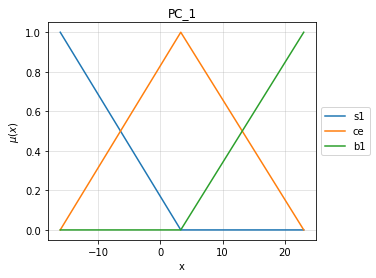

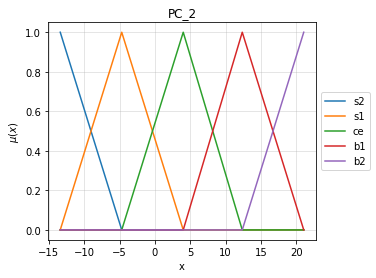

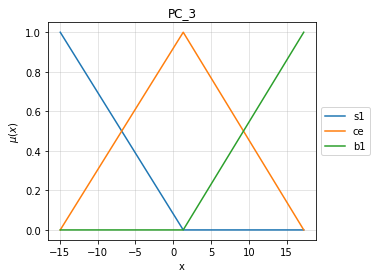

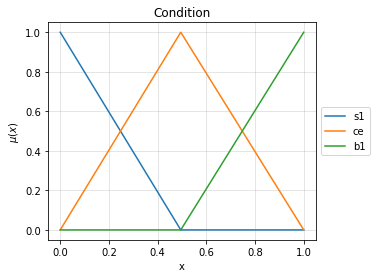

In [33]:
learning_system.plot_variables()

In [3]:
import matplotlib.pyplot as plt

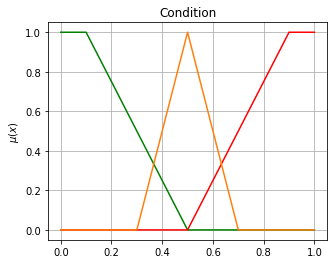

In [11]:
plt.figure(figsize=(5,4))

plt.title('Condition')
plt.ylabel(r'$\mu(x)$')
plt.plot([0, 0.1, 0.5, 1], [1, 1, 0, 0], color='green')
plt.plot([0, 0.5, 0.9, 1], [0, 0, 1, 1], color='red')
plt.plot([0, 0.3, 0.5, 0.7, 1], [0, 0, 1, 0, 0], color='tab:orange')
plt.grid()
plt.show()